<a href="https://colab.research.google.com/github/Lilol/DeepLearningHw/blob/main/CNN_vs_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning for cloud-image categorization
## Transformer and CNN rchitectures

#### Resources

Image preprocessing and augmentation: https://keras.io/api/preprocessing/

TensorFlow Hub Vision transformer pre-trained models: https://tfhub.dev/sayakpaul/collections/vision_transformer/1

Transfer learning using TensorFlow Hub pre-trained models: https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

Transfer learning universal tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning

## 1.) Data preprocessing

In [ ]:
# Install libraries
!pip install patool
!pip install pyunpack
!pip install tensorflow
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 8.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283858 sha256=70229fbbc246e6943751ab30b006da928fe20261a5c600a309f390a543b0bf7a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import numpy as np

### Download and unzip dataset

The dataset ("Swimcat-extend") contains 6 cloud categories, each in their corresponding directory.
There are 2100 images in total, 350 in each category.

In [ ]:
from pyunpack import Archive
from os.path import join, isdir
from os import remove
from shutil import rmtree, copytree
import patoolib
from urllib import request


def download_and_unzip_images(target_directory):
    inner_dir = join(target_directory, "Swimcat-extend")
    if isdir(inner_dir):
      rmtree(inner_dir)
    url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/vwdd9grvdp-2.zip'
    zip_file = join(target_directory, "images.zip")
    file_handle, _ = request.urlretrieve(url, zip_file)
    Archive(zip_file).extractall(target_directory)
    rar_file = join(target_directory, "Cloud-ImVN 1.0.rar")
    patoolib.extract_archive(rar_file, outdir=target_directory)
    remove(zip_file)
    remove(rar_file)
    return inner_dir

In [ ]:
# Download data
from numpy.random import seed, choice, permutation

seed(42)
input_location = "input/Swimcat-extend"

import os
os.makedirs(input_location, exist_ok=True)

input_location = download_and_unzip_images(input_location)

patool: Extracting input/Swimcat-extend/Cloud-ImVN 1.0.rar ...
patool: running /usr/bin/unrar x -- "/content/input/Swimcat-extend/Cloud-ImVN 1.0.rar"
patool:     with cwd='input/Swimcat-extend'
patool: ... input/Swimcat-extend/Cloud-ImVN 1.0.rar extracted to `input/Swimcat-extend'.


### Parameters for the training

Image height and width are given based on the pre-trained network input.

In [ ]:
batch_size = 64
img_height = 224
img_width = 224
seed = 10
IMAGE_SHAPE = (img_height, img_width)
validation_split = 0.2

### Training and validation datasets

In [ ]:
# Create training set
import tensorflow as tf

training_set = tf.keras.utils.image_dataset_from_directory(
    input_location,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=IMAGE_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=validation_split,
    subset="training",
)

Found 2100 files belonging to 6 classes.
Using 1680 files for training.


In [ ]:
# Create validation set
validation_set = tf.keras.utils.image_dataset_from_directory(
    input_location,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=IMAGE_SHAPE,
    seed=seed,
    validation_split=validation_split,
    subset="validation",
)

Found 2100 files belonging to 6 classes.
Using 420 files for validation.


In [ ]:
# Training labels
class_names = training_set.class_names
class_names

['A-Clear Sky',
 'B-Patterned Clouds',
 'C-Thin White Clouds',
 'D-Thick White Clouds',
 'E-Thick Dark Clouds',
 'F-Veil Clouds']

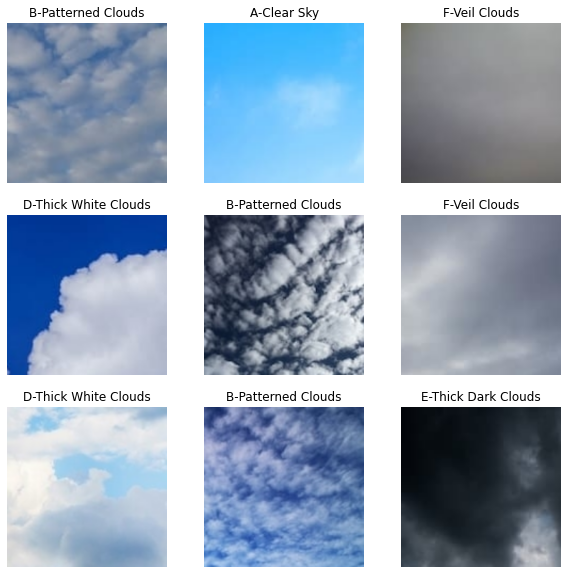

In [ ]:
# Quick look at the categories
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [ ]:
# Use prefetch mechanism to speed up the processing
AUTOTUNE = tf.data.AUTOTUNE

training_set = training_set.cache().prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

## 2.) Training ViT model
### Download and test pre-trained model from TensorFlow Hub

We used this model to test the vision transformer and our preprocessing mechanism before training.

The selected pre-trained model is the "vit_r26_s32_lightaug_classification" achitecture, a hybrid vision transformer (ViT) fine-tuned on ImageNet-1k. 

In [ ]:
# Download ViT classifier from tensorflow hub
import tensorflow_hub as hub

input = tf.keras.Input(shape=IMAGE_SHAPE+(3,))
normalization_layer = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255.)
])(input)

classifier_model ="https://tfhub.dev/sayakpaul/vit_r26_s32_lightaug_classification/1"

classifier = hub.KerasLayer(classifier_model)(normalization_layer)

model = tf.keras.Model(
    input,
    classifier
)

# This is a pre-trained model
model.compile()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1000)              36431912  
                                                                 
Total params: 36,431,912
Trainable params: 0
Non-trainable params: 36,431,912
_________________________________________________________________


### Download labels from the Imagenet website

To understand the output of the transformer, the labels belonging to each output class are downloaded from the Imagenet website.

In [ ]:
# Download labels from the imagenet website
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
with open("ilsvrc2012_wordnet_lemmas.txt", "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]
imagenet_int_to_str=np.array(imagenet_int_to_str)

--2022-11-20 19:29:28--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-11-20 19:29:29 (108 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



### Test the classifier
When testing the pre-trained model using cloud images, one can notice that the predictions are all objects usually portrayed with a sky-backgound, or large, blue geographical features like lakes or geysers.
Since there is no "cloud" category in Imagenet, these classes seem to have features closes to those of clouds.

In [ ]:
import matplotlib.pyplot as plt

def show_classifications(validation_set, labels, n_pred_lables_to_show=4, difference_with_red=False):
  # Check out a few classifications
  plt.figure(figsize=(15, 15))
  for images, actual_labels in validation_set.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      im = images[i].numpy()
      plt.imshow(im.astype("uint8"))

      actual_label = class_names[np.argmax(actual_labels[i])]
      print(f"Actual label: {actual_label}")

      # Print the first n strongest classifications
      predictions = model.predict(tf.expand_dims(im, 0).numpy())
      ind = np.argpartition(predictions, -n_pred_lables_to_show)[..., -n_pred_lables_to_show:]
      predicted_labels = labels[ind]
      print(f"Inferred labels: {predicted_labels[0]}")
      print("\n")

      color = 'black'
      if difference_with_red and predicted_labels[0, 0] != actual_label:
        color = 'red'
      plt.title(f"Class: {actual_label}\nPrediction: {predicted_labels[0, 0]}", color=color)
      plt.axis("off")

Actual label: E-Thick Dark Clouds
1/1 [==============================] - 57s 57s/step
Inferred labels: ['airship, dirigible' 'geyser' 'beacon, lighthouse, beacon_light, pharos'
 'volcano']


Actual label: A-Clear Sky
1/1 [==============================] - 0s 292ms/step
Inferred labels: ['geyser' 'seashore, coast, seacoast, sea-coast' 'sandbar, sand_bar'
 'promontory, headland, head, foreland']


Actual label: B-Patterned Clouds
1/1 [==============================] - 0s 299ms/step
Inferred labels: ['wing' 'airship, dirigible' 'parachute, chute' 'warplane, military_plane']


Actual label: F-Veil Clouds
1/1 [==============================] - 0s 298ms/step
Inferred labels: ['alp' 'beacon, lighthouse, beacon_light, pharos' 'geyser'
 'drilling_platform, offshore_rig']


Actual label: F-Veil Clouds
1/1 [==============================] - 0s 294ms/step
Inferred labels: ['drilling_platform, offshore_rig'
 'beacon, lighthouse, beacon_light, pharos' 'volcano' 'geyser']


Actual label: B-Patterned 

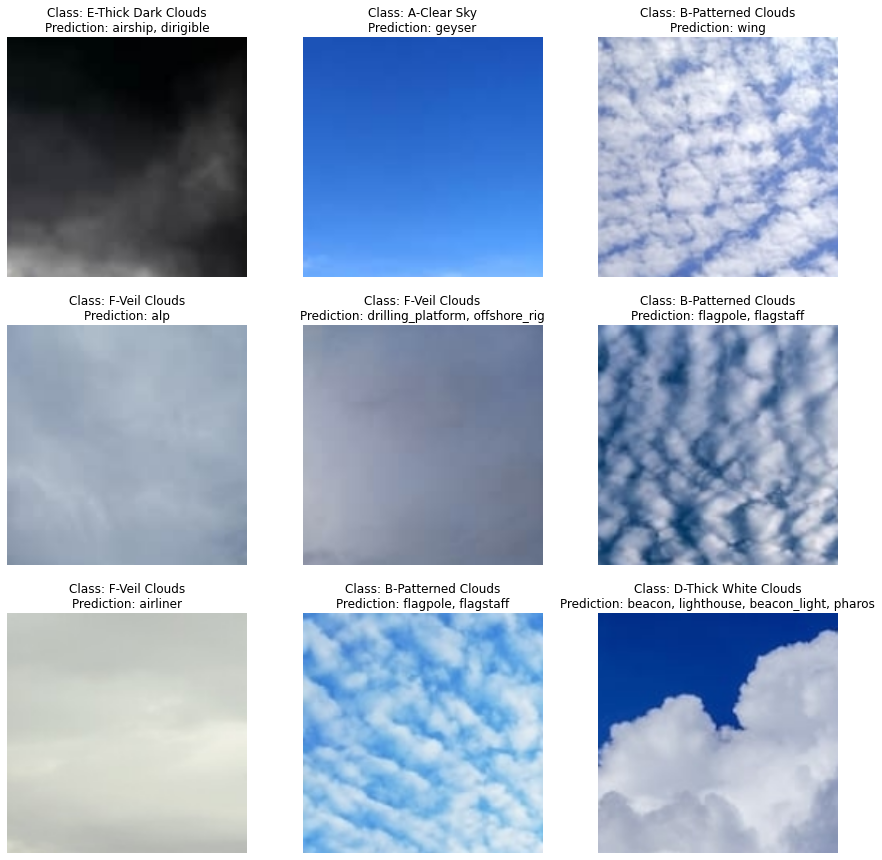

In [ ]:
show_classifications(validation_set, imagenet_int_to_str, 4)

### Transfer-learning
Download the feature model without the top layer and freeze the weights.

In [ ]:
import tensorflow_hub as hub

feature_extractor = "https://tfhub.dev/sayakpaul/vit_r26_s32_lightaug_fe/1"

feature_extractor_layer = hub.KerasLayer(
    feature_extractor,
    input_shape=IMAGE_SHAPE+(3,),
    trainable=False)

## Additional layers for the transfer learning

Add data augmentation layers before the model, and additional dropout and a dense layer after it.

In [ ]:
num_classes = len(class_names)

data_augmentation = [
  tf.keras.layers.Input(shape=IMAGE_SHAPE+(3,)),
  tf.keras.layers.Rescaling(1./255.),
  tf.keras.layers.RandomFlip(),
  tf.keras.layers.RandomRotation(0.8),
]

model = tf.keras.Sequential(
  data_augmentation + [
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 keras_layer_1 (KerasLayer)  (None, 384)               36046912  
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 6)                 2310      
                                                      

In [ ]:
# This step is necessary for the saving of the model during training
# For some reason, the weights does not have indicidual names out of the box
for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

In [ ]:
learning_rate = 1e-5

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

### Train the model

Hyperparameters like patience, epoch count and learning rate were tuned experimentally.
Using a relatively low learning rate ($10^{-5}$) and a large epoch count (400), the model converges to a 0.9 accuracy.

In [ ]:
tf.get_logger().setLevel('ERROR')

epochs = 400
from keras.callbacks import EarlyStopping, ModelCheckpoint

path_checkpoint = join("model_checkpoint.h5")
es_callback = EarlyStopping(monitor="val_loss", patience=20)

modelckpt_callback = ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(training_set, epochs=epochs, validation_data=validation_set, callbacks=[es_callback, modelckpt_callback])

Epoch 1/400
27/27 [==============================] - ETA: 0s - loss: 9.1722 - categorical_accuracy: 0.1381
Epoch 1: val_loss improved from inf to 9.10045, saving model to model_checkpoint.h5
27/27 [==============================] - 63s 1s/step - loss: 9.1722 - categorical_accuracy: 0.1381 - val_loss: 9.1004 - val_categorical_accuracy: 0.1214
Epoch 2/400
27/27 [==============================] - ETA: 0s - loss: 8.8268 - categorical_accuracy: 0.1423
Epoch 2: val_loss improved from 9.10045 to 8.84551, saving model to model_checkpoint.h5
27/27 [==============================] - 7s 266ms/step - loss: 8.8268 - categorical_accuracy: 0.1423 - val_loss: 8.8455 - val_categorical_accuracy: 0.1214
Epoch 3/400
27/27 [==============================] - ETA: 0s - loss: 8.5954 - categorical_accuracy: 0.1393
Epoch 3: val_loss improved from 8.84551 to 8.59128, saving model to model_checkpoint.h5
27/27 [==============================] - 7s 277ms/step - loss: 8.5954 - categorical_accuracy: 0.1393 - val_loss

## 3.) Evaluation and visualization of Vit model
### Accuracy and loss during the training



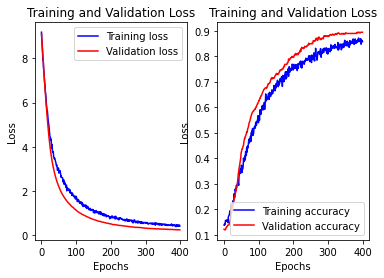

In [ ]:
import matplotlib.pyplot as plt


def visualize_metrics(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    acc = history.history["categorical_accuracy"]
    val_acc = history.history["val_categorical_accuracy"]
    epochs = range(len(loss))

    plt.figure()
    ax = plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, "b", label="Training accuracy")
    plt.plot(epochs, val_acc, "r", label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_metrics(history, "Training and Validation Loss")

### Evaluate results numerically using a confusion matrix

In [ ]:
def calc_confusion_matrix():
  # Confusion matrix
  # iterate over the dataset
  y_test=[]
  y_prediction = []
  for image_batch, label_batch in validation_set:   # use dataset.unbatch() with repeat
    # append true labels
    y_test.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    y_prediction.append(preds)

  # Convert the true and predicted labels into tensors
  correct_labels = tf.concat([np.argmax(item, axis=-1) for item in y_test], axis = 0)
  predicted_labels = tf.concat([np.argmax(item, axis=-1) for item in y_prediction], axis = 0)
  # Create confusion matrix and normalizes it over predicted (columns)
  return tf.math.confusion_matrix(correct_labels, predicted_labels)


  confusion_matrix = calc_confusion_matrix()
  print(confusion_matrix)

2/2 [==============================] - 2s 1s/step
tf.Tensor(
[[64  0  7  0  0  2]
 [ 0 70  2  0  0  1]
 [ 1  1 60  1  0  0]
 [ 0  0 11 62  0  1]
 [ 0  0  0  0 76  0]
 [ 2  0  0  3 12 44]], shape=(6, 6), dtype=int32)


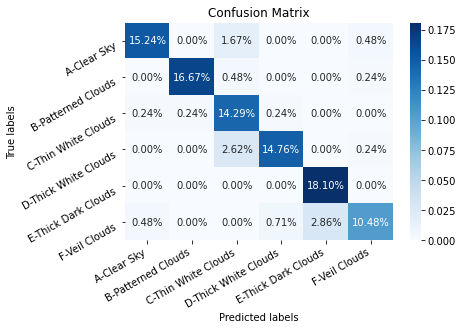

In [ ]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix):
  ax= plt.subplot()
  sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,fmt='.2%', cmap='Blues')
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(class_names)
  ax.yaxis.set_ticklabels(class_names)
  for label in ax.get_xmajorticklabels() + ax.get_ymajorticklabels():
      label.set_rotation(30)
      label.set_horizontalalignment("right")
      label.set_verticalalignment("top")

print_confusion_matrix(confusion_matrix)

### Check a couple of classifications

1/1 [==============================] - 0s 31ms/step
Actual label: A-Clear Sky
Inferred label: A-Clear Sky


1/1 [==============================] - 0s 40ms/step
Actual label: D-Thick White Clouds
Inferred label: D-Thick White Clouds


1/1 [==============================] - 0s 21ms/step
Actual label: E-Thick Dark Clouds
Inferred label: E-Thick Dark Clouds


1/1 [==============================] - 0s 24ms/step
Actual label: E-Thick Dark Clouds
Inferred label: E-Thick Dark Clouds


1/1 [==============================] - 0s 20ms/step
Actual label: C-Thin White Clouds
Inferred label: C-Thin White Clouds


1/1 [==============================] - 0s 28ms/step
Actual label: A-Clear Sky
Inferred label: A-Clear Sky


1/1 [==============================] - 0s 31ms/step
Actual label: B-Patterned Clouds
Inferred label: B-Patterned Clouds


1/1 [==============================] - 0s 42ms/step
Actual label: C-Thin White Clouds
Inferred label: C-Thin White Clouds


1/1 [==============================] - 0

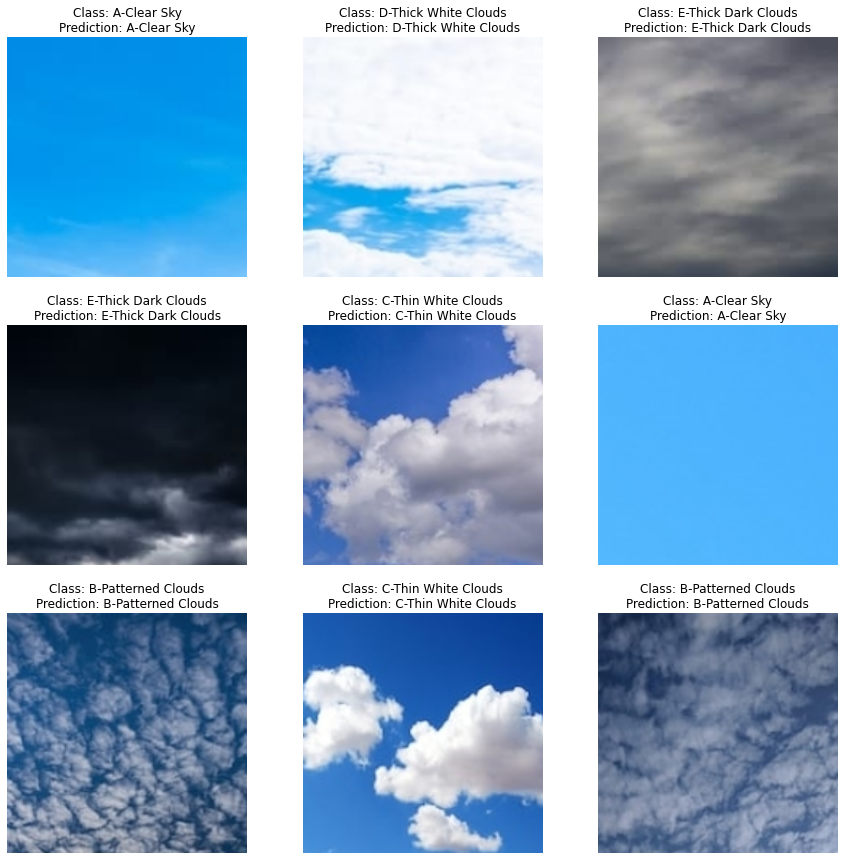

In [ ]:
import numpy as np
# Check out a few classifications
plt.figure(figsize=(15, 15))
for images, labels in validation_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    im = images[i].numpy()
    plt.imshow(im.astype("uint8"))
    # im = tf.cast(im, tf.float32)
    predictions = model.predict(tf.expand_dims(im, 0).numpy())
    ind = np.argmax(predictions)
    predicted_label = class_names[ind]
    print(f"Actual label: {class_names[np.argmax(labels[i])]}")
    print(f"Inferred label: {predicted_label}")
    print("\n")
    plt.title(f"Class: {class_names[np.argmax(labels[i])]}\nPrediction: {predicted_label}")
    plt.axis("off")

## 4.) Training CNN model
### Download and test pre-trained model from TensorFlow Hub

We used this model to test CNN architecture and our preprocessing mechanism before training.

The selected pre-trained model is the [VGG16](https://arxiv.org/abs/1409.1556), a deep CNN of 16 layers trained on more than a million images from the ImageNet database to recognize thousands of objects.

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras import models, layers, callbacks

## Load pre-trained
base = vgg16.VGG16(weights="imagenet", include_top=False, 
                   input_shape=(224,224,3))
base.trainable = False
 
## Add new head
cnn_model = models.Sequential(name="TransferLearning", layers=[
    base,
    layers.Flatten(name="flat"),
    layers.Dense(name="dense", units=128, activation='relu'),
    layers.Dense(name="y_out", units=6, activation="softmax")
])

cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
cnn_model.summary() 

Model: "TransferLearning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flat (Flatten)              (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 y_out (Dense)               (None, 6)                 774       
                                                                 
Total params: 17,926,854
Trainable params: 3,212,166
Non-trainable params: 14,714,688
_________________________________________________________________




## Train the model

In [ ]:
tf.get_logger().setLevel('ERROR')

epochs = 5  
from keras.callbacks import EarlyStopping

## Train
cnn_history = cnn_model.fit(training_set,
                     epochs=epochs, batch_size=2, 
                     validation_data=validation_set,
                     callbacks=[EarlyStopping(monitor="val_loss", patience=2)])

Epoch 1/5
27/27 [==============================] - 10s 364ms/step - loss: 3.6546 - accuracy: 0.7982 - val_loss: 0.8212 - val_accuracy: 0.9262
Epoch 2/5
27/27 [==============================] - 10s 359ms/step - loss: 0.1581 - accuracy: 0.9708 - val_loss: 0.3583 - val_accuracy: 0.9714
Epoch 3/5
27/27 [==============================] - 10s 364ms/step - loss: 0.0614 - accuracy: 0.9881 - val_loss: 0.2543 - val_accuracy: 0.9786
Epoch 4/5
27/27 [==============================] - 10s 368ms/step - loss: 0.0306 - accuracy: 0.9952 - val_loss: 0.5502 - val_accuracy: 0.9452
Epoch 5/5
27/27 [==============================] - 10s 371ms/step - loss: 0.0693 - accuracy: 0.9917 - val_loss: 0.3269 - val_accuracy: 0.9738


## 5. Evaluating CNN model
### Accuracy and loss during the training



In [ ]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], "o-", color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], "o-", label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], "o-", color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], "o-", label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

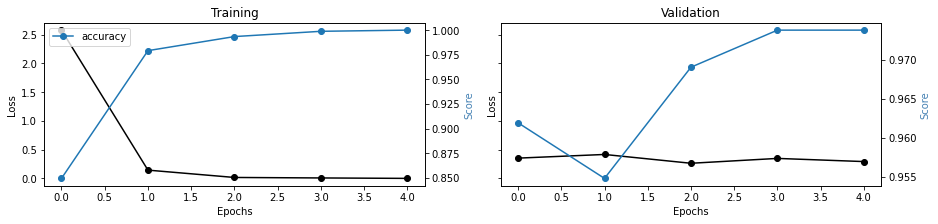

In [ ]:
utils_plot_training(cnn_history)

To understand why the model classifies images with a certain sky label and assess the explainability of the predictions we can use lime.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


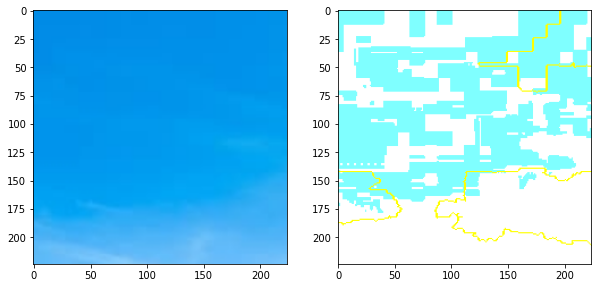

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


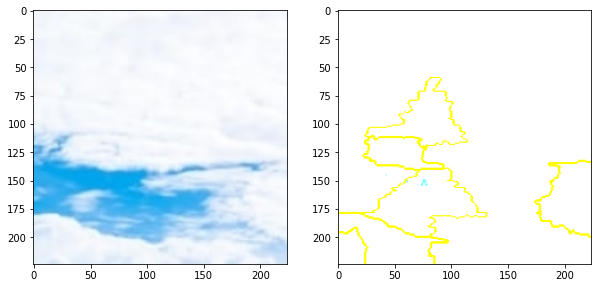

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


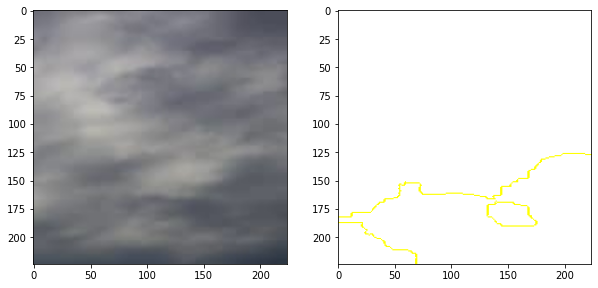

In [ ]:
## for explainer
from lime import lime_image
from skimage import segmentation

for images, labels in validation_set.take(1):
  for i in range(3):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    im = images[i].numpy()
    img_instance = im.astype("uint8")
    plt.imshow(im)
    ## explain
    explainer = lime_image.LimeImageExplainer()
    explained = explainer.explain_instance(img_instance, cnn_model.predict, num_samples=1000)

    ## visualize
    ax[0].imshow(img_instance)
    temp, mask = explained.get_image_and_mask(explained.top_labels[0], positive_only=False, hide_rest=False)
    ax[1].imshow(segmentation.mark_boundaries(temp/2+0.5, mask))
    plt.show()


### Evaluate results numerically using a confusion matrix



In [ ]:
def calc_cnn_confusion_matrix():
  # Confusion matrix
  # iterate over the dataset
  y_test=[]
  y_prediction = []
  for image_batch, label_batch in validation_set:   # use dataset.unbatch() with repeat
    # append true labels
    y_test.append(label_batch)
    # compute predictions
    preds = cnn_model.predict(image_batch)
    y_prediction.append(preds)

  # Convert the true and predicted labels into tensors
  correct_labels = tf.concat([np.argmax(item, axis=-1) for item in y_test], axis = 0)
  predicted_labels = tf.concat([np.argmax(item, axis=-1) for item in y_prediction], axis = 0)
  # Create confusion matrix and normalizes it over predicted (columns)
  return tf.math.confusion_matrix(correct_labels, predicted_labels)


cnn_confusion_matrix = calc_cnn_confusion_matrix()
print(cnn_confusion_matrix)

2/2 [==============================] - 1s 989ms/step
tf.Tensor(
[[71  0  1  1  0  0]
 [ 0 73  0  0  0  0]
 [ 0  0 59  3  1  0]
 [ 0  0  2 72  0  0]
 [ 0  0  0  0 76  0]
 [ 1  0  0  0  2 58]], shape=(6, 6), dtype=int32)


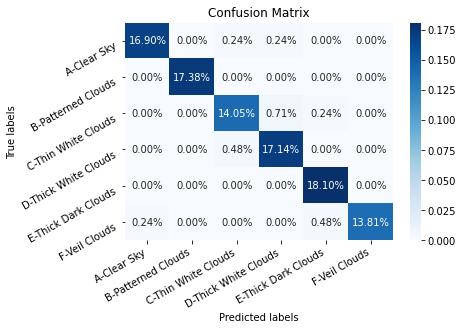

In [ ]:
print_confusion_matrix(cnn_confusion_matrix)